# Aumento de Resolución en Imágenes

El objetivo de esta práctica, como bien pone el título, es el aumento de la resolución de las imágenes. En este caso estaremos usando el conjunto de imágenes MNIST. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Preparación de los datos

In [ ]:
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)

In [ ]:
# Iterador para el conjunto de las imágenes
dataiter = iter(data_loader) 

images, labels = dataiter.next() # Preparamos el iterador, nos ponemos en su 1ª posición
print(torch.min(images), torch.max(images)) # En fución de los valores que nos salgan, usaremos una función de activación u otra. Si 0-1, sigmoide, si -1 - 1, Tanh

tensor(0.) tensor(1.)


# Autoencoder

Para poder conseguir nuestro objetivo, **quitaremos del encoder la 1ª capa convolutiva**. Más adelante explicaremos el por qué.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
                
        # N, 1, 14, 14 --> Un canal de entrada (capa), 14 de largo y 14 de ancho
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 5, stride=2, padding=3), 
            nn.ReLU(),
            nn.Conv2d(8, 16, 5, stride=2, padding=3), 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3)
        )
        
        # N , 64, 1, 1 --> 64 canales de entrada, 1 de alto y 1 de ancho, es decir, un vector (latente)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 7), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 4, stride=2, padding=3, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 5, stride=2, padding=3, output_padding=1), 
            nn.Sigmoid()
            # nn.Tanh()
        )

    def forward(self, x):
        #print(x.shape)
        encoded = self.encoder(x)
        #print(encoded.shape)
        decoded = self.decoder(encoded)
        #print(decoded.shape)
        return decoded

## Inicialización del modelo

In [ ]:
model = Autoencoder()

criterion = nn.MSELoss() # Función de pérdida
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5) # Adam es el mejor optimizador de redes neuronales, es el que provoca una convergencia más rápida

## Entrenamiento

Para poder aumentar la resolución, previamente **tendremos que reducir el tamaño de la imagen a la mitad**. Ello lo conseguimos haciendo un Resize de cada imagen.

La idea es que lo **guardemos en una variable temporal**, de forma que al final el criterion se mida en base al valor de la imagen original (sin transformar) y la imagen reconstruida.

In [ ]:
num_epochs = 10
outputs = []
transformacion = transforms.Resize(size = (14, 14)) # Reshape de la imagen a 14*14, como un Tensor

for epoch in range(num_epochs):
    for (img_original, _) in data_loader:
        #print(img_original.shape)
        img_transformada = transformacion(img_original)
        #print(img_transformada.shape)
        recon = model(img_transformada) # El recon debe ser el resultado del modelo con la imagen reshapeada con el transform
        #print(recon.shape)
        loss = criterion(recon, img_original) # Criterion entre la imagen original y el recon
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img_original, img_transformada, recon))

Epoch:1, Loss:0.0335
Epoch:2, Loss:0.0201
Epoch:3, Loss:0.0139
Epoch:4, Loss:0.0120
Epoch:5, Loss:0.0100
Epoch:6, Loss:0.0093
Epoch:7, Loss:0.0096
Epoch:8, Loss:0.0078
Epoch:9, Loss:0.0090
Epoch:10, Loss:0.0075


Existe una mejora sustancial, la pérdida disminuye.

# Pruebas

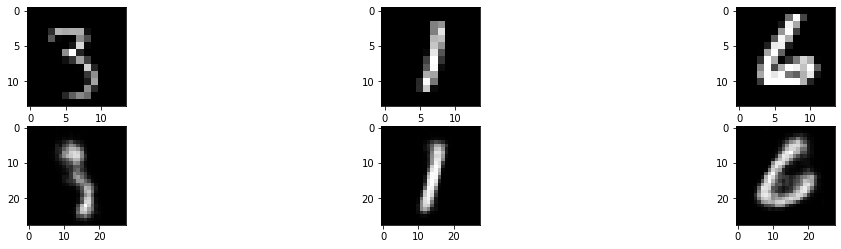

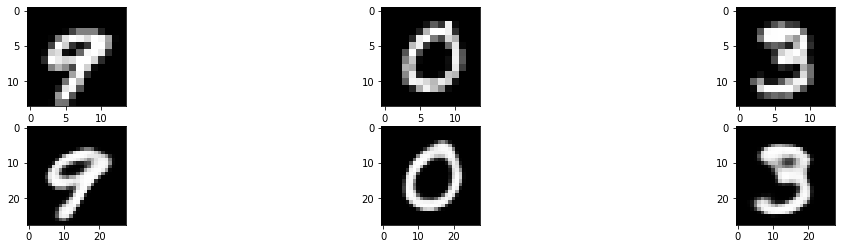

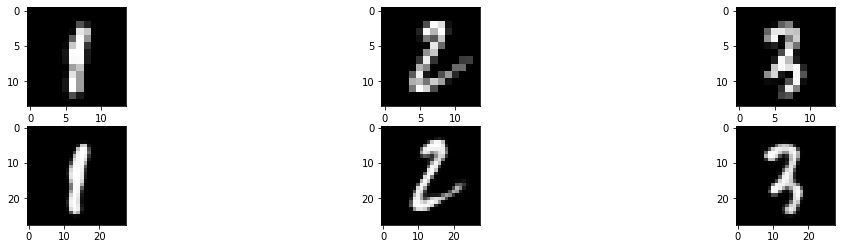

In [ ]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(18, 4)) # Para que se pueda ver la diferencia entre la imagen original y la reconstruida, mostraremos ambas bastante ampliadas.
    plt.gray()
    imgs_transformadas = outputs[k][2].detach().numpy() # Provocamos el aumento de tamaño
    recons = outputs[k][3].detach().numpy()
    for i, item in enumerate(imgs_transformadas):
        if i >= 3: break
        plt.subplot(2, 3, i+1) # Filas, columnas, posición de la imagen
        plt.imshow(item[0])
            
    for i, item in enumerate(recons):
        if i >= 3: break
        plt.subplot(2, 3, 3+i+1) # Filas, columnas, posición de la imagen
        plt.imshow(item[0])

## Comprobación con el conjunto de validación

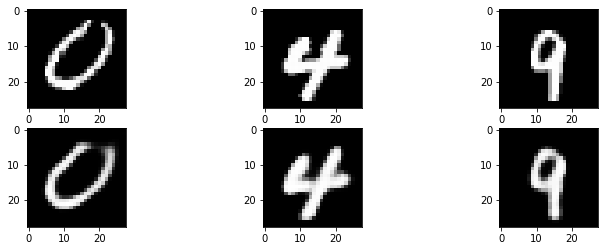

In [ ]:
model.eval()

# Iterador del conjunto de validación
dataiter = iter(data_loader_valid)
images, labels = dataiter.next()

img = images[0]
#print(img.shape)

plt.figure(figsize=(12, 4)) # figsize=(18,4)
plt.gray()


for i, img_original in enumerate(images[:3]):
    with torch.no_grad():
        img_transformada = transformacion(img_original) # Copia temporal reducida de tamaño a la mitad
        #print(img_transformada.shape)
        pred = model(img_transformada) # Imagen reconstruida, 28*28
        recon = pred.detach().numpy()
        #print(recon.shape)

        plt.subplot(2, 3, i+1)
        #print(img_original.shape)
        plt.imshow(img_original[0])

        plt.subplot(2, 3, i+1+3)
        plt.imshow(recon[0])

Podemos observar que, siendo la primera fila las imágenes originales y la segunda las mismas imágenes reconstruidas, se ve que las de abajo son capaces de discriminar un poquito mejor 